Confusion Matrix for MAP:

       L=1    L=2    L=3    L=4
D=1  0.765  0.030  0.102  0.077
D=2  0.019  0.899  0.021  0.059
D=3  0.120  0.022  0.774  0.076
D=4  0.096  0.049  0.102  0.788


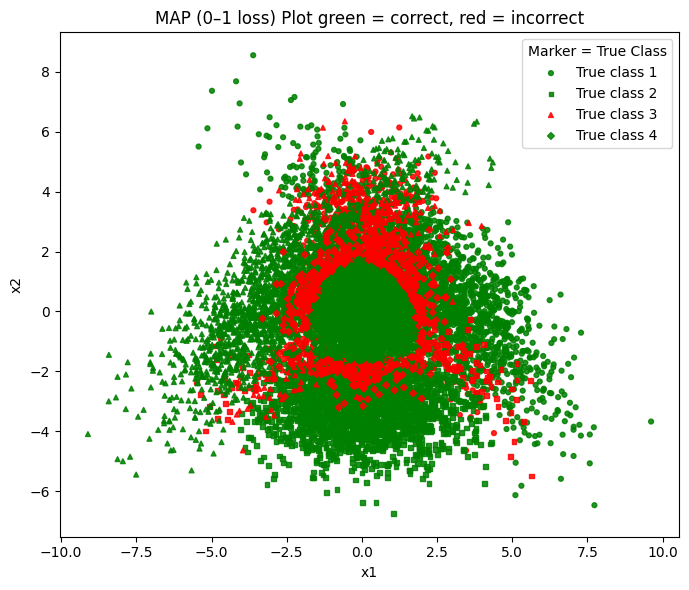


Saved Part A confusion CSV: \mnt\data\partA_confusion_MAP.csv
Saved Part A scatter PNG: \mnt\data\partA_MAP_scatter.png


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

rng = np.random.default_rng(5)
K = 4
N = 10000
priors = np.ones(K) * 0.25

MU = np.array([
    [ 2.0,  1.0], 
    [ 0.0, -3.0],   
    [-2.0,  1.0], 
    [ 0.0,  0.0],  
])

SIGMA = np.array([
    [[ 4.0, -3.0],
     [-3.0,  4.0]],
    [[ 3.0,  0.0],
     [ 0.0,  1.0]],
    [[ 4.0,  3.0],
     [ 3.0,  4.0]],
    [[ 1.0,  0.0],
     [ 0.0,  1.0]],
])

labels_true = rng.integers(0, K, size=N)
X = np.empty((N, 2), dtype=float)
for k in range(K):
    idx = (labels_true == k)
    X[idx] = rng.multivariate_normal(MU[k], SIGMA[k], size=idx.sum())

out_dir = Path("/mnt/data")
out_dir.mkdir(parents=True, exist_ok=True)
np.savez(out_dir / "q2_part_dataset.npz", X=X, labels_true=labels_true, MU=MU, SIGMA=SIGMA, priors=priors)

def log_gaussian(x, mean, cov, inv_cov=None, logdet=None):
    d = x.shape[1]
    if inv_cov is None or logdet is None:
        inv_cov = np.linalg.inv(cov)
        sign, logdet = np.linalg.slogdet(cov)
        if sign <= 0:
            raise ValueError("Covariance not SPD.")
    xc = x - mean
    m = np.einsum('ni,ij,nj->n', xc, inv_cov, xc)
    return -0.5 * (m + d*np.log(2*np.pi) + logdet)

def confusion_matrix(decisions, labels, K=4):
    counts = np.zeros((K, K), dtype=int)
    for j in range(K):
        mask = (labels == j)
        d = decisions[mask]
        for i in range(K):
            counts[i, j] = np.count_nonzero(d == i)
    probs = counts / counts.sum(axis=0, keepdims=True)
    return counts, probs

markers = {0: 'o', 1: 's', 2: '^', 3: 'D'}

def plot_correctness(X, labels_true, decisions, title, png_path):
    colors = np.where(decisions == labels_true, 'green', 'red')
    plt.figure(figsize=(7, 6))
    for k in range(K):
        sel = (labels_true == k)
        plt.scatter(X[sel,0], X[sel,1], marker=markers[k], c=colors[sel], s=12, alpha=0.85, label=f"True class {k+1}")
    plt.xlabel("x1"); plt.ylabel("x2"); plt.title(title)
    plt.legend(title="Marker = True Class", loc="best", scatterpoints=1)
    plt.tight_layout(); plt.savefig(png_path, dpi=160); plt.show()

invC = [np.linalg.inv(SIGMA[k]) for k in range(K)]
logdetC = [np.linalg.slogdet(SIGMA[k])[1] for k in range(K)]
loglik = np.column_stack([log_gaussian(X, MU[k], SIGMA[k], invC[k], logdetC[k]) for k in range(K)])
logpost = loglik + np.log(priors)
decisions_map = np.argmax(logpost, axis=1)

counts_map, probs_map = confusion_matrix(decisions_map, labels_true, K=K)

map_df = pd.DataFrame(probs_map.round(3),
                      index=[f"D={i}" for i in range(1, K+1)],
                      columns=[f"L={j}" for j in range(1, K+1)])
print("Confusion Matrix for MAP:\n")
print(map_df)

map_csv = out_dir / "partA_confusion_MAP.csv"
map_png = out_dir / "partA_MAP_scatter.png"
map_df.to_csv(map_csv, float_format="%.6f")

plot_correctness(X, labels_true, decisions_map,
                 "MAP (0–1 loss) Plot green = correct, red = incorrect",str(map_png))

print(f"\nSaved Part A confusion CSV: {map_csv}\nSaved Part A scatter PNG: {map_png}")

Confusion Matrix for ERM:

       L=1    L=2    L=3    L=4
D=1  0.219  0.004  0.002  0.000
D=2  0.039  0.492  0.002  0.001
D=3  0.102  0.026  0.384  0.000
D=4  0.640  0.478  0.613  0.998

Estimated Minimum Expected Risk: 0.5309


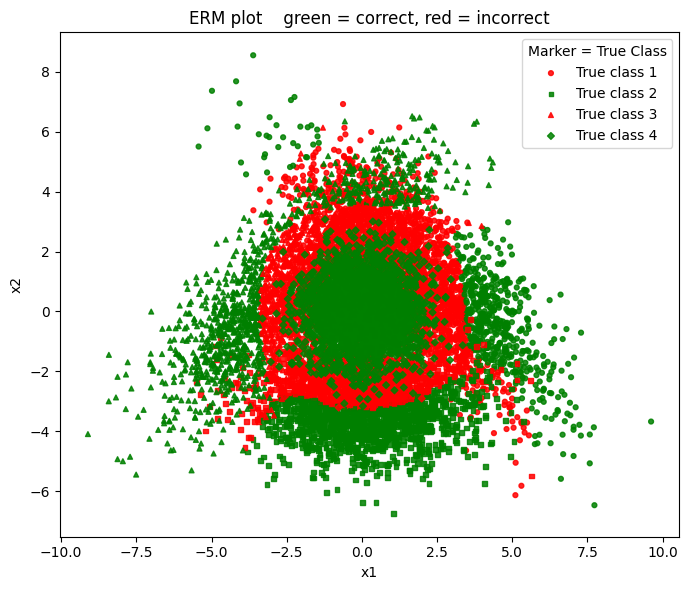


Saved Part B confusion CSV: /mnt/data/partB_confusion_ERM.csv
Saved Part B scatter PNG: \mnt\data\partB_ERM_scatter.png


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

data = np.load("/mnt/data/q2_part_dataset.npz", allow_pickle=True)
X = data["X"]
labels_true = data["labels_true"]
MU = data["MU"]
SIGMA = data["SIGMA"]
priors = data["priors"]

K = 4

LAMBDA = np.array([
    [0, 10, 10, 100],
    [1,  0, 10, 100],
    [1,  1,  0, 100],
    [1,  1,  1,   0],
])

def log_gaussian(x, mean, cov, inv_cov=None, logdet=None):
    d = x.shape[1]
    if inv_cov is None or logdet is None:
        inv_cov = np.linalg.inv(cov)
        sign, logdet = np.linalg.slogdet(cov)
        if sign <= 0:
            raise ValueError("Covariance not SPD.")
    xc = x - mean
    m = np.einsum('ni,ij,nj->n', xc, inv_cov, xc)
    return -0.5 * (m + d*np.log(2*np.pi) + logdet)

def confusion_matrix(decisions, labels, K=4):
    counts = np.zeros((K, K), dtype=int)
    for j in range(K):
        mask = (labels == j)
        d = decisions[mask]
        for i in range(K):
            counts[i, j] = np.count_nonzero(d == i)
    probs = counts / counts.sum(axis=0, keepdims=True)
    return counts, probs

markers = {0:'o',1:'s',2:'^',3:'D'}

def plot_correctness(X, labels_true, decisions, title, png_path):
    colors = np.where(decisions == labels_true, 'green', 'red')
    plt.figure(figsize=(7,6))
    for k in range(K):
        sel = (labels_true == k)
        plt.scatter(X[sel,0], X[sel,1], marker=markers[k],
                    c=colors[sel], s=12, alpha=0.85, label=f"True class {k+1}")
    plt.xlabel("x1"); plt.ylabel("x2"); plt.title(title)
    plt.legend(title="Marker = True Class", loc="best", scatterpoints=1)
    plt.tight_layout(); plt.savefig(png_path, dpi=160); plt.show()

invC = [np.linalg.inv(SIGMA[k]) for k in range(K)]
logdetC = [np.linalg.slogdet(SIGMA[k])[1] for k in range(K)]
loglik = np.column_stack([log_gaussian(X, MU[k], SIGMA[k], invC[k], logdetC[k]) for k in range(K)])

like_prior = np.exp(loglik + np.log(priors))
R_vals = (LAMBDA @ like_prior.T).T
decisions_erm = np.argmin(R_vals, axis=1)

counts_erm, probs_erm = confusion_matrix(decisions_erm, labels_true, K=K)
R_hat = float(LAMBDA[decisions_erm, labels_true].mean())

erm_df = pd.DataFrame(probs_erm.round(3),
                      index=[f"D={i}" for i in range(1, K+1)],
                      columns=[f"L={j}" for j in range(1, K+1)])
print("Confusion Matrix for ERM:\n")
print(erm_df)
print(f"\nEstimated Minimum Expected Risk: {R_hat:.4f}")

png_path = Path("/mnt/data/partB_ERM_scatter.png")
plot_correctness(X, labels_true, decisions_erm,"ERM plot    green = correct, red = incorrect",str(png_path))

erm_df.to_csv("/mnt/data/partB_confusion_ERM.csv", float_format="%.6f")
print(f"\nSaved Part B confusion CSV: /mnt/data/partB_confusion_ERM.csv\nSaved Part B scatter PNG: {png_path}")